# CS4049 Assignment 2 - Atari Deep Learning

In [74]:
# !pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]
# !apt-get install -y xvfb python-opengl ffmeg > /def/null 2>&1

# !pip install atari_py==0.2.6 gym==0.17.2 keras-rl2 pyglet
# !pip install -U colabgymrender

In [1]:
# For deep neural networks
import tensorflow.compat.v1 as tf
import tf_slim as slim

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt

# OpenAI Gym
import gym
env = gym.make("Assault-v0")
# I have installed pyglet-1.5.11 for it work with BigSur

OSError: [WinError 126] The specified module could not be found

In [76]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



# Reinforcement Learning with Frames

## Task 1.1: Create Environment (Investigate Action Space)

In [77]:
# Describe Action & Observation Space
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

env.reset()
next_obs, reward, done, info = env.step(0)
print(info)

Action space:  Discrete(7)
Observation space:  Box(250, 160, 3)
{'ale.lives': 4}


In [78]:
# class RandomAgent():
#     def __init__(self, env):
#         self.action_size = env.action_space.n
#
#     def get_action(self, observation):
#         return random.choice(range(self.action_size))
#
# reward_episodes = []
# numberOfEpisodes = 10
# agent = RandomAgent(env)
# for ep in range(numberOfEpisodes):
#     current_obs = env.reset()
#     done = False
#     total_reward_ep = 0
#     while not done:
#         action = agent.get_action(current_obs)
#         next_obs, reward, done, info = env.step(action)
#         env.render()
#         total_reward_ep += reward
#     reward_episodes.append(total_reward_ep)
#
# print("Average reward per episode: {}".format(np.sum(reward_episodes)/numberOfEpisodes))
# env.close()

Average reward per episode: 216.3


## Task 1.3: Pre-Processing

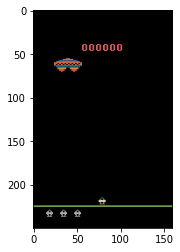

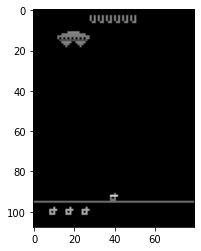

In [79]:
obs = env.reset()

def preprocess_observations(observation):

    # Slice Top Off
    img = observation[34:250:2, ::2]

    # Grey Scale
    img = img.mean(axis=2)
    img = (img - 128).astype(np.int8)

    return img.reshape(108, 80, 1)

plt.imshow(obs)
plt.show()
plt.imshow(preprocess_observations(obs).reshape(108, 80), cmap="gray", vmin=-128, vmax=127)

## Task 1.4: Implement Deep Convolutional Network

### Create Deep Convolutional Network

In [80]:
def q_network(X_state, name):
    prev_layer = X_state / 128 #the values will be between [-1, 1]
    initializer = tf.variance_scaling_initializer()
    hidden_activation = tf.nn.relu
    with tf.variable_scope(name) as scope:
        prev_layer = tf.layers.conv2d(prev_layer, filters=32,
                                      kernel_size = 8, strides = 4,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size = 4, strides = 2,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size = 3, strides = 1,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape= [-1, 64 * 12*10])
        hidden = tf.layers.dense(last_conv_layer_flat, 512,
                                 activation = hidden_activation, kernel_initializer = initializer)
        outputs = tf.layers.dense(hidden, env.action_space.n, kernel_initializer = initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = { var.name[len(scope.name):] : var for var in trainable_vars}
    return outputs, trainable_vars_by_name

### Create Using Deep Convolutional Network

In [81]:
class QLearningAgent():
    def __init__(self, env, learning_rate = 0.001, momemtum = 0.95):
        self.action_size = env.action_space.n
        self.loss_val = np.infty
        tf.reset_default_graph()
        tf.disable_eager_execution()

        self.discount_rate = 0.99

        self.checkpoint_path = "./my_dqn_boxing.ckpt"

        self.X_state = tf.placeholder(tf.float32, shape= [None, 96, 80, 1])
        self.online_q_values, self.online_vars = q_network(self.X_state, name = "q_networks/online")
        self.target_q_values, self.target_vars = q_network(self.X_state, name = "q_networks/target")

        #Define the operations to copy the online network to the target network
        self.copy_ops = [ target_var.assign(self.online_vars[var_name])
                          for var_name, target_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)

        # The structure of the training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32, shape=[None])
            self.y = tf.placeholder(tf.float32, shape=[None, 1])
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),
                                         axis=1, keepdims = True)

            self.error = tf.abs( self.y - self.q_value) #A value between 0 and infty
            self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0) #If it is above 1 then it becomes 1
            self.linear_error = 2 * (self.error - self.clipped_error)
            self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)

            self.global_step = tf.Variable(0, trainable = False, name = "global_step")
            self.optimizer = tf.train.MomentumOptimizer(learning_rate, momentum = momemtum, use_nesterov = True)
            self.training_op = self.optimizer.minimize(self.loss, global_step = self.global_step)

        # Saving
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)

    def get_action(self, q_values, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(q_values)



    def train(self, state_val, action_val, reward, next_state_val, continues):
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state : np.array([next_state_val])})
        max_next_q_values = np.max(next_q_values , axis = 1, keepdims= True)
        #We can now compute the target value
        y_val = reward + continues * self.discount_rate *max_next_q_values
        _ , self.loss_val = self.sess.run([self.training_op, self.loss],
                                          feed_dict= {self.X_state: np.array([state_val]),
                                                      self.X_action: np.array([action_val]),
                                                      self.y : y_val})

### Train Model for 1,000,000 Training Steps

In [82]:
agent = QLearningAgent(env)


n_steps = 1000000
copy_steps = 5000
save_steps = 1000

with agent.sess:
    while True:
        step = agent.global_step.eval()
        if step >= n_steps:
            break


        print("\r\t Training step {}/{} ({:.1f})% \t Loss{:5f}".format(step,n_steps,step*100/ n_steps,agent.loss_val), end="")

        if done:
            obs = env.reset()
            state = preprocess_observation(obs)

        q_values = agent.online_q_values.eval(feed_dict={
            agent.X_state : [state]})
        action = agent.get_action(q_values,step)

        #We play the action from the agent
        next_obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(next_obs)
        agent.train(state, action, reward, next_state, 1.0 - done)

        env.render()

        state = next_state

        if step % copy_steps ==0:
            agent.copy_online_to_target.run()

        if step % save_steps ==0:
            agent.saver.save(agent.sess, agent.checkpoint_path)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.Dense instead.
	 Training step 0/1000000 (0.0)% 	 Loss  inf

NameError: name 'preprocess_observation' is not defined

# Reinforcement Learning with RAM

# Reinforcement Learning by Mixing Screen and RAM